In [399]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,6]

# <font color='color'> Introduction </font>

A robot is moving across a circular corridor. We assume that the possible positions of the robot is **a discrete set with
N locations**.
Given the robot sensors' measurements $Y_i$, $i \in (1..K)$, we aim to modelize the robot's real position (hidden variable $X_i$, $i \in (1..K)$) following the *Hidden Markov chain* model
![alt text](https://raw.githubusercontent.com/AymenMT/Robot-s-position-estimation/master/p2.PNG "*Hidden Markov chain*")

This will allow us to simulate the scenario and to estimate some important distributions such as the robot's current position given the observations so far and the most likely current position of the robot given the observations so far...



# <font color='color'> Question 0 : Numerically Stable computation of $log(\sum exp(l_i))$ </font>


Before starting to modelize our problem, we implement a stable computation method of $L = log(\sum exp(l_i))$. In fact, the more $l_i$ is low, the harder it becomes to calculate the expression directly. To insure the stability of the computation, one method consists at introducing $l_{max} = max_i {l_i}$ in the expression of $L$ as following:

\begin{align}
log(\sum exp(l_i)) &= log(\sum exp(l_i - l_{max} + l_{max})) \\
           &= log( exp(l_{max})  \sum exp(l_i - l_{max})) \\
           &= l_{max} + log(\sum exp(l_i - l_{max}))
\end{align}

In [400]:
def calculate_log_sum_exp(v):
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - np.repeat(v_max, len(v)))))

#### Exemple d'application : 

If we try to calculate directly $L$, for $l = \begin{pmatrix} -1234 \\ -1235\end{pmatrix}$, we obtain :

In [401]:
l = [-1234, -1235]
np.log(np.sum(np.exp(l)))

C:\Users\MTIBAA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


-inf

But if we use our stable method, we obtain :

In [402]:
calculate_log_sum_exp(l)

-1233.6867383124818

# <font color='color'> Question 1 : Model definition </font>

As presented in the introduction, in order to modelize our problem, we define two variables : 

* $X_i$ $\in$ {1,..N}, i $\in$ {1,..K} : a *hidden variable* which express the real position of the robot in the step k
* $Y_i$ $\in$ {1,..N}, i $\in$ {1,..K} : an observation variable which express the observed position of the robot using its sensors in the step k

The generative model is represented by the transition model and the observations model : 

* Transition model : $x_k \sim P( x_{k+1} | x_k )$

* Observation model : $y_k \sim P( y_{k} | x_k )$  

![alt text](https://raw.githubusercontent.com/AymenMT/Robot-s-position-estimation/master/p2.PNG "*Hidden Markov chain*")

In order to build our transition and observation models, a prior was set as following : 

1. The initial position of the robot is unknown and assumed to be uniformly distributed

2. At each step k, the robot stays where it is with probability $\epsilon$, or moves to the next point in counter-clock direction with probability $1- \epsilon$

3. At each step k, the robot can observe its true position with probability $w$. With probability $1 - w$, the position sensor fails and gives a measurement that is independent from the true position (uniformly distributed).

# <font color='color'> Question 2 : Transition & Observation models definition </font>

#### <font color='color'> Transition model</font> ####

Following the second prior introduced in the previous question, we can set $P(x_{k+1} | x_k)$  (**Transition model**) as following :

$$
\forall j \in (1,..,N-1), \quad \mathbb{P}(x_{k+1} = i | x_k = j) = \left\{
    \begin{array}{ll}
        1- \epsilon & \mbox{si } i = j + 1  \\
        \epsilon & \mbox{si } i = j \\
        0 & \mbox{sinon }
    \end{array}
\right.
$$

Note that if $j = N$, $\mathbb{P}(x_{k+1} = 1 | x_k = N) = 1 - \epsilon$  (The robot moves to the next point in counter-clock direction), and $\mathbb{P}(x_{k+1} = N | x_k = N) = \epsilon$

#### <font color='color'> Observation model</font> ####
Now, we aim to calculate the **observation matrix** $(\mathbb{P}( y_{k} = i | x_k = j))_{i,j}$. In fact, in order to detect the right position at a step k $(i == j)$, we have to possibilities : 

1. The robot observe its true position (probability = $w$)
2. The robot fails to observe its right position (probability = $1 - w$) and select a random position. In this case, we have a $1/N$ probability to select the right position

We can conclude that if $i = j$, $\mathbb{P}( y_{k} = i | x_k = j) = w + 1/N (1 - w)$

In the other hand, and for all the other cases where  $ i \ne j$, we have $\mathbb{P}( y_{k} = i | x_k = j) = 1/N (1 - w)$

#### <font color='color'> Conclusion</font> ####

** 1. Transition matrix** : 
\begin{align}
T \quad &= \quad \left(\begin{array}{ccccc}
\epsilon&0&\cdots&\cdots&1-\epsilon\\
1-\epsilon&\epsilon&\ddots&\ddots&0\\
0&1-\epsilon&\ddots&0&\vdots\\
\vdots&{}&\ddots&\ddots&0\\
0&0&\cdots&1-\epsilon&\epsilon
\end{array}\right)
\end{align}

** 2. Observation matrix** : 
\begin{align}
O \quad &= \quad \left(\begin{array}{ccccc}
w + 1/N(1-w)&1/N(1-w)&\cdots&\cdots&1/N(1-w)\\
1/N(1-w)&w + 1/N(1-w)&\ddots&\ddots&\vdots\\
\vdots&1/N(1-w)&\ddots&\ddots&\vdots\\
\vdots&{}&\ddots&\ddots&\vdots\\
\vdots&{}&\ddots&\ddots&1/N(1-w)\\
1/N(1-w)&\cdots&\cdots&1/N(1-w)&w + 1/N(1-w)
\end{array}\right)
\end{align}

#### <font color='color'> Parameters definition</font> ####

In [403]:
# Number of states
N = 50
# Epsilon
eps = 0.3 
# w 
w = 0.8 
# Moves number :
K = 100

#### <font color='color'> Implementation of the transition matrix</font> ####

In [404]:
# Transition model 
# T == Transition matrix
T = np.zeros((N,N))
i,j = np.indices(A.shape)
T[i == j] = eps
T[i == j + 1] = (1-eps)
T[0,N - 1] = 1 - eps

In [405]:
T

array([[0.3, 0. , 0. , ..., 0. , 0. , 0.7],
       [0.7, 0.3, 0. , ..., 0. , 0. , 0. ],
       [0. , 0.7, 0.3, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.3, 0. , 0. ],
       [0. , 0. , 0. , ..., 0.7, 0.3, 0. ],
       [0. , 0. , 0. , ..., 0. , 0.7, 0.3]])

#### <font color='color'> Implementation of the observation matrix</font> ####

In [406]:
# Observation matrix
# Oij = p ( Yk = i | Xk = j) : Observation matrix


O = ((1 / N) * (1 - w)) * np.ones((N,N))
i,j = np.indices(O.shape)
O[i == j] = w + (1 / N) * (1 - w)

In [407]:
O

array([[0.804, 0.004, 0.004, ..., 0.004, 0.004, 0.004],
       [0.004, 0.804, 0.004, ..., 0.004, 0.004, 0.004],
       [0.004, 0.004, 0.804, ..., 0.004, 0.004, 0.004],
       ...,
       [0.004, 0.004, 0.004, ..., 0.804, 0.004, 0.004],
       [0.004, 0.004, 0.004, ..., 0.004, 0.804, 0.004],
       [0.004, 0.004, 0.004, ..., 0.004, 0.004, 0.804]])

#### <font color='color'> Matrices verification : stochastic ?</font> ####

In [408]:
print ('Dimensions de T = ' + str(T.shape))
print ('Sum of the Sum of columns of T = ' + str(np.sum(np.sum(T,axis = 1))))
print ('Sum of the Sum of rows of T = ' + str(np.sum(np.sum(T,axis = 0))))

Dimensions de T = (50, 50)
Sum of the Sum of columns of T = 50.0
Sum of the Sum of rows of T = 50.0


In [409]:
print ('Dimensions de O = ' + str(O.shape))
print ('Sum of the Sum of columns of O = ' + str(np.sum(np.sum(O,axis = 1))))
print ('Sum of the Sum of rows of O = ' + str(np.sum(np.sum(O,axis = 0))))

Dimensions de O = (50, 50)
Sum of the Sum of columns of O = 50.0
Sum of the Sum of rows of O = 50.0


# <font color='color'> Question 3 : Posterior quantities </font>

Here, we're going to express some posterior quantities in a mathematical notation. We will calculate some of them later.

**1. Distribution of the robot's current position given the observations so far :** $\quad p(x_{k} | y_{1:k} )$


**2. Distribution of the robot's position at time step k given all the observations :** $\quad p(x_{k} | y_{1:K} )$


**3. Distribution of the robot's next position given the observations so far :** $\quad p(x_{k+1} | y_{1:k} )$


**4. Distribution of the robot's next sensor reading given the observations so far : **$\quad p(y_{k+1} | y_{1:k} )$


**5. Distribution of the robot's initial position given observations so far :** $\quad p(x_{1} | y_{1:k} )$


**6. Most likely current position of the robot given the observations so far : **$\quad max_{i} \quad p(x_{k} = i\quad | \quad y_{1:k} )$


**7. Most likely trajectory taken by the robot from the start until now given the observations so far :** $\quad argmax_{x_{1:k}}\quad p(x_{1:k}| y_{1:k} )$

# <font color='color'> Question 4 : Scenario simulation </font>

In [410]:
def hmm_generate_data(trans_matrix, obs_matrix, K):
    """ 
    This function takes transition and observation matrices and simulate states and observations path
    following those distributions
    
    input :
    trans_matrix : matrix N*N, dtype = int(N*N)
    obs_matrix : matrix N*N, dtype = int(N*N)
    
    Output : 
    states : a vector of K simulated states, dtype = int(K)
    obs : a vector of K simulated observations, dtype = int(K)
    """
    states = np.zeros(K, dtype=int);
    obs = np.zeros(K, dtype=int)

    # First state : 
    states[0] = int(np.random.randint(low=1, high=N, size=1))
    # First observation :
    obs[0] = int(np.random.choice(np.arange(1,N + 1), 1, p=obs_matrix[:,states[0] - 1]))

    for k in np.arange(1, K):

        states[k] = int(np.random.choice(np.arange(1,N + 1), 1, p=trans_matrix[ :, states[k - 1] - 1 ]))
        obs[k] = int(np.random.choice(np.arange(1,N + 1), 1, p=obs_matrix[:,states[k] - 1]))
        
    return states, obs

#### <font color='color'> Simulation example</font> ####

In [457]:
states, obs = hmm_generate_data(T, O, K)

#### <font color='color'> Plot of states and observations</font> ####

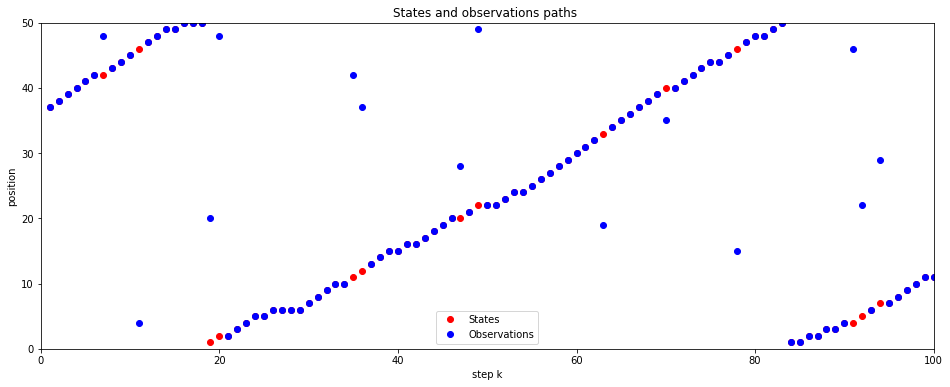

In [458]:
plt.plot(np.arange(1, K+1), states, 'ro',   label='States')
plt.plot(np.arange(1, K+1), obs, 'bo',   label='Observations')
plt.axis([0,100,0,50])
plt.xlabel('step k')
plt.ylabel('position')
plt.title('States and observations paths ')
plt.legend()
plt.show()

**Interpretations : **

* We can see that most of the observations are the same as the states simulations (real positions). This is because of our choice of $w$. In fact, the probability of having an observation equal to the real state is much higher than having a random position ( $w + 1/N(1-w) - 1/N(1-w) = w = 0.8$)

* We can also see that we have states as a stair function of k. This is because of the nature of our problem (the robot moves to the next point in counter-clock direction) 

# <font color='color'> Question 5 : Forward-Backward algorithm </font>

### a- Forward algorithm to calculate the distribution of the robot's current position given the observations so far : $\quad p(x_{k} | y_{1:k} )$

![alt text](https://raw.githubusercontent.com/AymenMT/Robot-s-position-estimation/master/p3.PNG "*Hidden Markov chain*")

###### Principe

By applying the *product rule*, we obtain : 

\begin{align}
P( x_k | y_{1:k} ) &= \frac{P( x_k , y_{1:k} )}{P(y_{1:k})} 
\end{align}

If we write $ \alpha_{k|k}(x_k) = P( x_k , y_{1:k} ) $, we obtain : 

\begin{align}
P(y_{1:k}) &= \sum_{x_k} P(y_{1:k}, x_k)\\
           &= \sum_{x_k} \alpha_{k|k}(x_k)
\end{align}

**Finally, we have :
\begin{align}
P( x_k | y_{1:k}
) &= \frac{\alpha_{k|k}(x_k)}{\sum_{x_k} \alpha_{k|k}(x_k)} 
\end{align}** 

In order to calculate $\alpha_{k|k}(x_k)$, an iterative method is proposed : Forward algorithm. It consists at two steps : 

<font color='color'> **1. Prediction **: </font> 

\begin{align}
\alpha_{k|k-1}(x_k) &= P( y_{1:k-1}, x_k ) = \sum_{x_{k-1}} P( x_k | x_{k - 1} ) P( y_{1:k-1} | x_{k-1} ) \\
                    &= \sum_{x_{k-1}} P( x_k | x_{k - 1} ) \alpha_{k-1|k-1}(x_{k-1}), with \quad \alpha_{1|0}(x_{1}) = p(x1)
\end{align}

<font color='color'> **2. Update **: </font> 

\begin{align}
\alpha_{k|k}(x_k) &= P( y_{1:k}, x_k ) = P( y_{k}| x_k ) P( y_{1:k-1}, x_k ) \\
                    &= P( y_{k}| x_k ) \alpha_{k|k-1}(x_k)
\end{align}

### Prediction function

In this step, we will calculate  $\log \alpha$ instead of $\alpha$. Then, we will use the stable numerical calculations in ordre to make the prediction.

In [459]:
def state_predict(trans_matrix, log_alpha_k_k):
    """
    This function makes the prediction step (in logarithm)
    input :
    trans_matrix : (N*N) matrix, dtypes = int(N,N)
    log_alpha_k_k : vector(N) : updated message, dtypes = ndarray(N)
    
    output
    predicted_message : log_alpha_k_(k-1) :vector(N), dtypes = ndarray(N)
    """
    max_log_alpha_k_k = np.max(log_alpha_k_k)
    
    p = np.exp(log_alpha_k_k - max_log_alpha_k_k)
    predicted_message = max_log_alpha_k_k + np.log(np.dot(trans_matrix,p))
    
    return(predicted_message)

In [460]:
def state_update(obs_vector, log_alpha_k_k_1):
    """
    This function makes the update step (in logarithm)
    input :
    obs_vector : (N*N) matrix, dtypes = int(N,N)
    log_alpha_k_k_1 : vector(N) : predicted message, dtypes = ndarray(N)
    
    output
    updated_message : log_alpha_k_k :vector(N), dtypes = ndarray(N)
    """
    updated_message = np.log(obs_vector) + log_alpha_k_k_1
    return(updated_message)

In [461]:
def forward_algorithm (obs_matrix, trans_matrix, p_x1, observations , N, k):
    """
    This is the forward_algorithm function from the step 1 to step k
    input :
    obs_matrix : (N*N) matrix, dtypes = int(N,N)
    trans_matrix : (N*N) matrix, dtypes = int(N,N)
    p_x1 : first state distribution, dtypes = ndarray(N)
    observations : sequence of observations from step 1 to k, , dtypes = int(k)
    N : Number of states, dtype=int
    k : Number of steps, dtype=int
    
    output
    log_alpha_k_(k-1) :matrix(N*k) contains all predicted_messages from step 1 to k, dtypes = ndarray(N*k)
    log_alpha_k_k : contains all updated_messages from step 1 to k, dtypes = ndarray(N*k)
    """
    log_alpha_k_k_1 = np.zeros((N, k))
    log_alpha_k_k = np.zeros((N, k))
    
    # initialisation : log (alpha 1|0) : alpha j|j-1 pour j == 1
    log_alpha_k_k_1[:,0] =  np.log(p_x1)
    
    # update & predict from j == 2 to j == K 
    for j in np.arange(1, k): # j commence de 1 pour l'accès au matrices :
        # update
        y_k = observations[j - 1]
        log_alpha_k_k[:,j - 1] = state_update(obs_matrix[y_k - 1, :], log_alpha_k_k_1[:, j - 1])
        
        #predict
        log_alpha_k_k_1[:, j] = state_predict(trans_matrix, log_alpha_k_k[:, j - 1])
    
    # calculate log_alpha_k_k ( k here is the last step)
    y_k = observations[j]
    log_alpha_k_k[:,j] = state_update(obs_matrix[y_k - 1, :], log_alpha_k_k_1[:, j])
    return (log_alpha_k_k, log_alpha_k_k_1)

#### Example : Calculation of $\alpha_{k|k}\quad and \quad\alpha_{k|k-1} \forall k \in (1,..K)$

In [462]:
k = K
p_x1 = 1/N * np.ones(N)
observations = obs[:K]
log_alpha_k_k, log_alpha_k_k_1 = forward_algorithm (O, T, p_x1, observations , N, k)
alpha_k_k = np.exp(log_alpha_k_k)
alpha_k_k_1 = np.exp(log_alpha_k_k_1)


**Given a step number k, we calculate the distribution of the robot's current position given the observations so far by running : forward_algorithm (O, T, p_x1, observations , N, k) or simply : 
most_likely_pos[k-1]**

$P( x_k | y_{1:k})\quad \forall \quad k  \in (1..K)$

In [463]:
result = alpha_k_k / np.sum(alpha_k_k, 0)

**Given a step number k, we calculate the distribution of the robot's current position given the observations so far by running : forward_algorithm (O, T, p_x1, observations , N, k) or simply : 
result[k-1]**

In [464]:
result.shape

(50, 100)

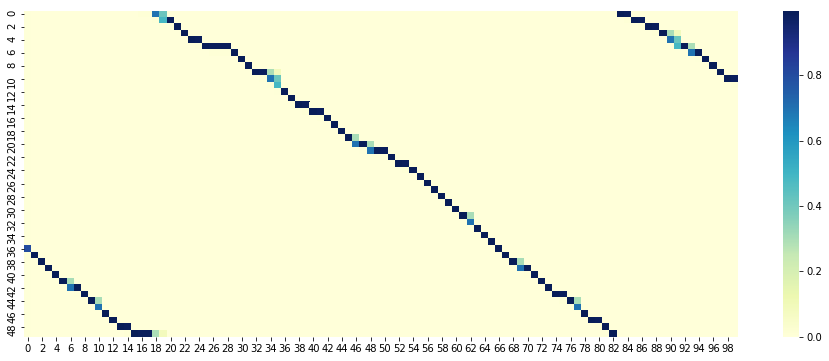

In [465]:
#Heatmap of p(Xk | Y1:k)
# Here in this graph, the position 0 corresponds to the first state X1
p1 = sns.heatmap(result, cmap="YlGnBu")


### b- Forward-Backward algorithm to calculate the distribution of the robot's position at time step k given all the observations : $\quad p(x_{k} | y_{1:K} )$

###### Principe

We can calculate the distribution of the robot's position at time step k given all the observations using the following formula:  

\begin{align}
P( x_k | y_{1:K} ) &= P(  y_{1:k}, x_k  ) P(  y_{k+1:K}, x_k  ) \\
                   &= \alpha_{k|k}(x_k) \cdot \beta_{k|k + 1}(x_k)
\end{align}

If we write $ P( x_k | y_{1:K} ) = \gamma_{k|k}(x_k) $, we obtain : 

**\begin{align}
\gamma_{k|k}(x_k)  &= \alpha_{k|k}(x_k) \cdot \beta_{k|k + 1}(x_k)
\end{align}**



In order to calculate $\beta_{k|k + 1}(x_k)$, an iterative method is proposed : Backward algorithm. It consists at two steps : 

<font color='color'> **1. Postdic **: </font> 

\begin{align}
\beta_{k|k + 1}(x_k) &= P(  y_{k+1:K}, x_k  ) = \sum_{x_{k+1}} P( x_{k+1} | x_{k} ) P( y_{k+1:K} | x_{k+1} ) \\
                    &= \sum_{x_{k+1}} P( x_{k+1} | x_{k} ) \beta_{k + 1|k + 1}(x_{k+1}), with \quad \beta_{K|K + 1}(x_{K}) = 1
\end{align}

<font color='color'> **2. Update **: </font> 

\begin{align}
\beta_{k|k}(x_k) &= P( y_{k:K}| x_k ) = P( y_{k}| x_k ) P( y_{k+1:K}, x_k ) \\
                    &= P( y_{k}| x_k ) \beta_{k|k + 1}(x_k)
\end{align}

### Postdict function

In this step, we will calculate  $\log \beta$ instead of $\beta$. Then, we will use the stable numerical calculations in ordre to calculate the result.

In [466]:
def state_postdict(trans_matrix, log_beta_k_plus_k_plus):
    """
    This function makes the postidct step (in logarithm)
    input :
    trans_matrix : (N*N) matrix, dtypes = int(N,N)
    log_beta_k_plus_k_plus : vector(N) : updated message, dtypes = ndarray(N)
    
    output
    postdict_message : log_beta_k_(k+1) :vector(N), dtypes = ndarray(N)
    """
    max_log = np.max(log_beta_k_plus_k_plus)
    p = np.exp(log_beta_k_plus_k_plus - max_log)
    postdict_message = np.log(np.dot(np.transpose(trans_matrix),p)) + max_log
    return(postdict_message)

In [467]:
np.arange(K - 1, -1 , -1)

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [468]:
def backward_algorithm(obs_matrix, trans_matrix, observations , N, K):
    """
    This is the backward_algorithm function from the step K to step 1
    input :
    obs_matrix : (N*N) matrix, dtypes = int(N,N)
    trans_matrix : (N*N) matrix, dtypes = int(N,N)
    observations : sequence of observations from step 1 to K, , dtypes = int(k)
    N : Number of states, dtype=int
    K : Number of steps, dtype=int
    
    output
    log_beta_k_k :matrix(N*K) contains all updated_messages from step 1 to k, dtypes = ndarray(N*k)
    log_beta_k_k_plus : contains all pstdict_messages from step 1 to k, dtypes = ndarray(N*k)
    """
    log_beta_k_k_plus = np.zeros((N, K))
    log_beta_k_k = np.zeros((N, K))
    
    # initialisation : log (beta K|K+1) = log (np.ones(N)) = np.zeros(N)
    log_beta_k_k_plus[:,-1] =  np.zeros(N)
    
    # update & predict from j == K to j == 1 
    for j in np.arange(K - 1, 0 , -1): 
        # update
        y_j = observations[j]
        log_beta_k_k[:,j] = state_update(obs_matrix[y_j - 1, :], log_beta_k_k_plus[:, j])
        
        #predict
        log_beta_k_k_plus[:, j - 1] = state_postdict(trans_matrix, log_beta_k_k[:, j])
        
    return (log_beta_k_k, log_beta_k_k_plus)
    

In [469]:
k = 0
log_beta_k_k, log_beta_k_k_plus = backward_algorithm(O, T, obs , N, K)
beta_k_k = np.exp(log_beta_k_k)
beta_k_k_plus = np.exp(log_beta_k_k_plus)

In [470]:
log_gamma_k = log_alpha_k_k + log_beta_k_k_plus

In [471]:
gamma_k = np.exp(log_gamma_k)

In [472]:
gamma_k = gamma_k / np.sum(gamma_k, 0)

**Given a step number k, we calculate the distribution of the robot's position at time step k given all the observations by running : 
gamma_k[k-1]**

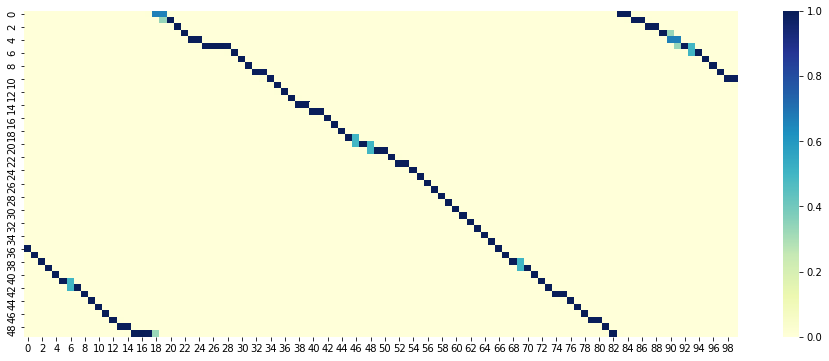

In [473]:
#We plot gamma_k heatmap
# Here in this graph, the position 0 corresponds to the first state X1
p1 = sns.heatmap(gamma_k, cmap="YlGnBu")

### c- Calculate the most likely current position of the robot given the observations so far : $\quad max_{i} \quad p(x_{k} = i\quad | \quad y_{1:k} )$

###### Principe

In **question 5-a**, we calculated the **distribution of the robot's current position given the observations so far** : $\quad p(x_{k} | y_{1:k} ) \quad \forall k \quad \in (1..K)$ (at all steps).

Now we aim to calculate the most likely position of the robot in each step, knowing only the observations so far. To do so, we need to find the position with the highest probability in each vector related to the step k. 

In [474]:
result = alpha_k_k / np.sum(alpha_k_k, 0)
most_likely_pos = np.argmax(result,0) + 1 # the first element of the vector (indice = 0) corresponds to the postion X = 1

**Given a step number k, we calculate the most likely current position of the robot given the observations so far by running : 
most_likely_pos[k-1]**

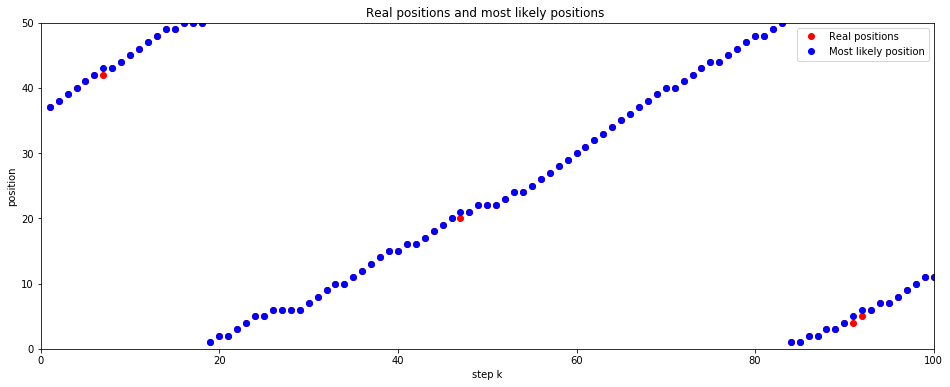

In [475]:
plt.plot(np.arange(1, K+1), states, 'ro',   label='Real positions')
plt.plot(np.arange(1, K+1), most_likely_pos, 'bo',   label='Most likely position')
plt.axis([0,100,0,50])
plt.xlabel('step k')
plt.ylabel('position')
plt.title('Real positions and most likely positions ')
plt.legend()
plt.show()

# <font color='color'> Question 6 : new prior  </font>

In this question, we assume that the robot can be kidnapped at each step k. This assumption implies that **our transition model needs to be adjusted**. In the other hand, **the observation model doesn't need any update.** In fact, the sensors still can detect the real position with a probabilities w.


At each step k, we have **two possibilities** : 

1. With a probability equal to $\kappa$, the robot will be kidnapped. In this case :
\begin{align}
p(x_{k+1} = i | x_k = j)  &=p(x_{k+1} = i)  &= \left(\begin{array}{c}
1/N \\ \vdots \\ 1/N
\end{array}\right)
\end{align}

2. With a probability equal to $1 - \kappa$, the robot will not be kidnapped. In this case :

$$
\forall j \in (1,..,N-1), \quad \mathbb{P}(x_{k+1} = i | x_k = j) = \left\{
    \begin{array}{ll}
        1- \epsilon & \mbox{si } i = j + 1  \\
        \epsilon & \mbox{si } i = j \\
        0 & \mbox{sinon }
    \end{array}
\right.
$$
Note that, for the second case, if $j = N$, $\mathbb{P}(x_{k+1} = 1 | x_k = N) = 1 - \epsilon$  (The robot moves to the next point in counter-clock direction), and $\mathbb{P}(x_{k+1} = N | x_k = N) = \epsilon$

#### <font color='color'> New Transition model</font> ####

Following this new prior, we can set $P(x_{k+1} | x_k)$  (**Transition model**) as following :

$$
\forall j \in (1,..,N-1), \quad \mathbb{P}(x_{k+1} = i | x_k = j) = \left\{
    \begin{array}{ll}
        (1 - \kappa)(1- \epsilon) + \kappa/N & \mbox{si } i = j + 1  \\
        (1 - \kappa)\epsilon  + \kappa/N & \mbox{si } i = j \\
        \kappa/N & \mbox{sinon }
    \end{array}
\right.
$$

Note that if $j = N$, $\mathbb{P}(x_{k+1} = 1 | x_k = N) = (1 - \kappa)(1- \epsilon) + \kappa/N $  (The robot moves to the next point in counter-clock direction), and $\mathbb{P}(x_{k+1} = N | x_k = N) = (1 - \kappa)\epsilon  + \kappa/N$


#### <font color='color'> New Transition matrix</font> ####

\begin{align}
T \quad &= \quad \left(\begin{array}{cccc}
(1 - \kappa)\epsilon  + \kappa/N&\kappa/N&\cdots&(1 - \kappa)(1- \epsilon) + \kappa/N\\
(1 - \kappa)(1- \epsilon) + \kappa/N&(1 - \kappa)\epsilon  + \kappa/N&\ddots&\kappa/N\\
\kappa/N&(1 - \kappa)(1- \epsilon) + \kappa/N&\ddots&\vdots\\
\vdots&\ddots&\ddots&\kappa/N\\
\kappa/N&\cdots&(1 - \kappa)(1- \epsilon) + \kappa/N&(1 - \kappa)\epsilon  + \kappa/N
\end{array}\right)
\end{align}


### <font color='color'> a- New simulation with a new transition model</font>

**We can reuse our pervious codes** to simulate new states and observations and to estimated the previous distributions mentionned in question 5. The only exception is that **we need to change the new transition matrix.**

In [476]:
kappa = 0.1
# Transition model 
# T == Transition matrix
T = np.ones((N,N)) * kappa/N

i,j = np.indices(T.shape)
T[i == j] = (1 - kappa)*eps + (kappa/N)
T[i == j + 1] = (1 - kappa)*(1 - eps) + (kappa/N)
T[0,N - 1] = (1 - kappa)*(1 - eps) + (kappa/N)

In [477]:
T

array([[0.272, 0.002, 0.002, ..., 0.002, 0.002, 0.632],
       [0.632, 0.272, 0.002, ..., 0.002, 0.002, 0.002],
       [0.002, 0.632, 0.272, ..., 0.002, 0.002, 0.002],
       ...,
       [0.002, 0.002, 0.002, ..., 0.272, 0.002, 0.002],
       [0.002, 0.002, 0.002, ..., 0.632, 0.272, 0.002],
       [0.002, 0.002, 0.002, ..., 0.002, 0.632, 0.272]])

#### <font color='color'> Matrices verification : stochastic ?</font> ####

In [478]:
print ('Dimensions de T = ' + str(T.shape))
print ('Sum of the Sum of columns of T = ' + str(np.sum(np.sum(T,axis = 1))))
print ('Sum of the Sum of rows of T = ' + str(np.sum(np.sum(T,axis = 0))))

Dimensions de T = (50, 50)
Sum of the Sum of columns of T = 50.0
Sum of the Sum of rows of T = 50.0


In [479]:
states, obs = hmm_generate_data(T, O, K)

#### <font color='color'> Plot of states and observations</font> ####

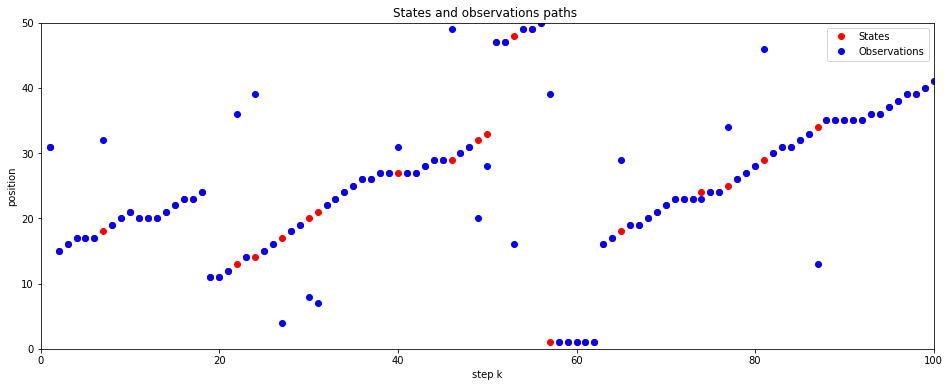

In [480]:
plt.plot(np.arange(1, K+1), states, 'ro',   label='States')
plt.plot(np.arange(1, K+1), obs, 'bo',   label='Observations')
plt.axis([0,100,0,50])
plt.xlabel('step k')
plt.ylabel('position')
plt.title('States and observations paths ')
plt.legend()
plt.show()

### <font color='color'> a- New estimations </font>

##### Forward algorithm to calculate the distribution of the robot's current position given the observations so far : $\quad p(x_{k} | y_{1:k} )$

In [481]:
k = K
p_x1 = 1/N * np.ones(N)
observations = obs[:K]
log_alpha_k_k, log_alpha_k_k_1 = forward_algorithm (O, T, p_x1, observations , N, k)
alpha_k_k = np.exp(log_alpha_k_k)
alpha_k_k_1 = np.exp(log_alpha_k_k_1)


**Given a step number k, we calculate the distribution of the robot's current position given the observations so far by running : forward_algorithm (O, T, p_x1, observations , N, k) or simply : 
most_likely_pos[k-1]**

$P( x_k | y_{1:k})\quad \forall \quad k  \in (1..K)$

In [482]:
result = alpha_k_k / np.sum(alpha_k_k, 0)

**Given a step number k, we calculate the distribution of the robot's current position given the observations so far by running : forward_algorithm (O, T, p_x1, observations , N, k) or simply : 
result[k-1]**

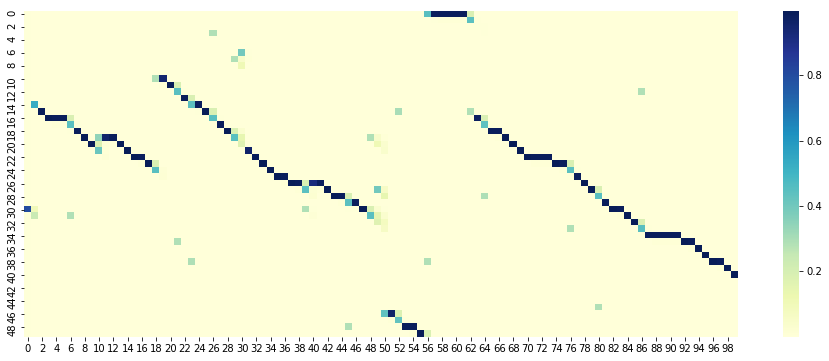

In [483]:
#Heatmap of p(Xk | Y1:k)
# Here in this graph, the position 0 corresponds to the first state X1
p1 = sns.heatmap(result, cmap="YlGnBu")


##### Forward-Backward algorithm to calculate the distribution of the robot's position at time step k given all the observations : $\quad p(x_{k} | y_{1:K} )$

In [484]:
k = 0
log_beta_k_k, log_beta_k_k_plus = backward_algorithm(O, T, obs , N, K)
beta_k_k = np.exp(log_beta_k_k)
beta_k_k_plus = np.exp(log_beta_k_k_plus)

In [485]:
log_gamma_k = log_alpha_k_k + log_beta_k_k_plus

In [486]:
gamma_k = np.exp(log_gamma_k)

In [487]:
gamma_k = gamma_k / np.sum(gamma_k, 0)

**Given a step number k, we calculate the distribution of the robot's position at time step k given all the observations by running : 
gamma_k[k-1]**

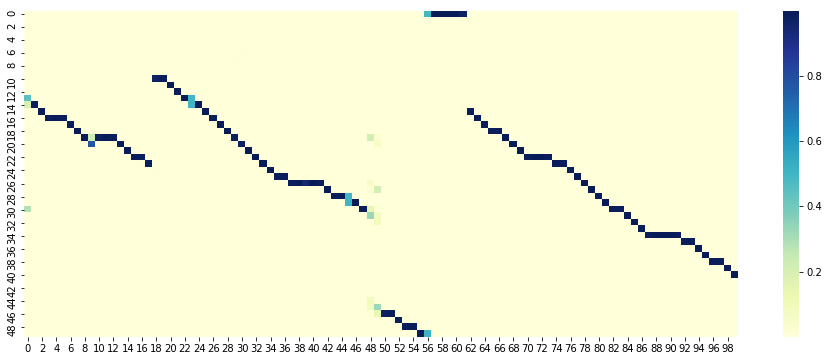

In [488]:
#We plot gamma_k heatmap
# Here in this graph, the position 0 corresponds to the first state X1
p1 = sns.heatmap(gamma_k, cmap="YlGnBu")

##### Most likely current position of the robot given the observations so far : $\quad max_{i} \quad p(x_{k} = i\quad | \quad y_{1:k} )$

In [489]:
result = alpha_k_k / np.sum(alpha_k_k, 0)
most_likely_pos = np.argmax(result,0) + 1 # the first element of the vector (indice = 0) corresponds to the postion X = 1

**Given a step number k, we calculate the most likely current position of the robot given the observations so far by running : 
most_likely_pos[k-1]**

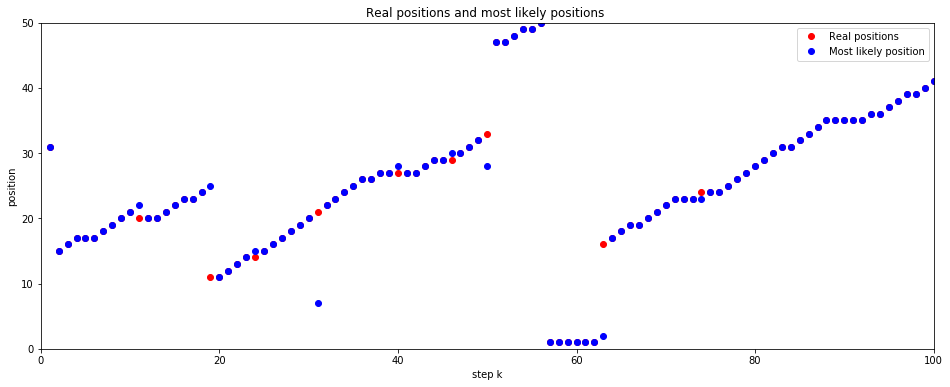

In [490]:
plt.plot(np.arange(1, K+1), states, 'ro',   label='Real positions')
plt.plot(np.arange(1, K+1), most_likely_pos, 'bo',   label='Most likely position')
plt.axis([0,100,0,50])
plt.xlabel('step k')
plt.ylabel('position')
plt.title('Real positions and most likely positions ')
plt.legend()
plt.show()